# 의료영상 종류

## X-RAY
- X-RAY는 전자를 물체에 충돌시킬 때 발생하는 투과력이 강한 복사선(전자기파)

- X-RAY는 방사선의 일종으로 지방, 근육, 천, 종이같이 밀도가 낮은 것은 수월하게 통과하지만, 밀도가 높은 뼈, 금속 같은 물질은 잘 통과하지 못함

### X-RAY 영상을 촬영하기 위해 사용되는 자세 분류

- Sagittal plane : 시상면. 사람을 왼쪽과 오른쪽을 나누는 면.

- Coronal plane : 관상면. 인체를 앞뒤로 나누는 면.

- Transverse plane : 횡단면(수평면). 인체를 상하로 나누는 면.

### X-RAY에 나오는 색깔
- 뼈 : 하얀색

- 근육 및 지방 : 연한 회색

- 공기 : 검은색



## CT
- CT는 Computed Tomography의 줄임말로, 환자를 중심으로 X-RAY를 빠르게 회전하여 3D 이미지를 만들어내는 영상
 
- 환자의 3 차원 이미지를 형성하여 기본 구조는 물론 가능한 종양 또는 이상을 쉽게 식별하고 위치를 파악할 수 있음
 
- 신체의 단면 이미지를 "Slice"라고 합니다. 이러한 Slice는 단층 촬영 이미지라고도 하며 기존의 X-RAY보다 더 자세한 정보를 포함

## MRI

- MRI는 Magnetic Resonance Imaging(자기 공명 영상)의 줄임말

- 신체의 해부학적 과정과 생리적 과정을 보기 위해 사용하는 의료 영상 기술

- MRI 스캐너는 강한 자기장를 사용하여 신체 기관의 이미지를 생성

- MRI는 CT, X-RAY와 다르게 방사선을 사용하지 않아서 방사선의 위험성에서는 보다 안전

# 폐렴 진단하기

# 필요한 모듈 불러오기

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
#데이터 로드할 때 빠르게 로드할 수 있도록 하는 설정변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
#X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

#데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

#프로젝트를 진행할 때 아래 두 변수 변경해보기
BATCH_SIZE = 32
EPOCHS = 15

# 데이터 가져오기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


### val 개수가 너무 적어서 train에서 val에 쓰일 데이터 가져오기
- train : val = 80 : 20

In [4]:
#train데이터와 validation 데이터를 모두 filenames에 담기
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

#모아진 filenames를 8:2로 나눔
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


## 정상 이미지와 폐렴 이미지 구분
- 파일경로에 힌트!

In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


파일 경로에 NORMAL이 있는 지 확인하면 정상 이미지를 셀 수 있음

In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f'Pneumonia images count in training set : {COUNT_PNEUMONIA}')

# 폐렴 이미지 수가 3배 더 많이 있음

Normal images count in training set: 1072
Pneumonia images count in training set : 3113


이번 과제에 사용할 CNN 모델의 경우 데이터가 클래스별 balance가 좋을 수록 training을 잘 하기 때문에 데이터 클래스가 imbalance한 건 차후에 조정

test와 val은 평가하기 위해서 사용하기 때문에 학습과 관련이 없으므로 imbalance여도 상관 없음

## tf.data 인스턴스 생성
- tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있게 해줌

### mini-batch 참고 링크

https://acdongpgm.tistory.com/202

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
# Train, validation 데이터셋 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f'Training images count: {TRAIN_IMG_COUNT}')

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f'Validating images count: {VAL_IMG_COUNT}')

Training images count: 4185
Validating images count: 1047


## 파일 경로를 이용해서 라벨 데이터를 만들어주는 함수 생성
- 파일 경로의 끝에서 두 번 째 부분을 확인하면 양성과 음성을 구분할 수 있음

In [9]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
                    #파일 경로를 자르는 코드(여기선 아마 / 기준으로 나누는 듯)
    return parts[-2]  == "PNEUMONIA"   #폐렴이면 양성(True), 노말이면 음성(False)

## 이미지 사이즈를 통일시키고 줄여주는 함수 생성

In [10]:
#이미지를 알맞은 형식으로 바꿈
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32)  # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

#이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옴
def process_path(file_path):
    label = get_label(file_path)  #라벨 검출
    img = tf.io.read_file(file_path)  #이미지 읽기
    img = decode_img(img)  #이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

### num_parallel_calls

- 데이터 추출 최적화 방법. 병렬 처리 수준 지정

다중 CPU를 사용하여 데이터 추출 프로세스를 병렬화하기 위해 시스템의 다중 코어를 활용하기 위해 다중 스레드를 생성

머신의 코어 수를 찾아 지정할 수 있지만 더 나은 옵션은 tf.data.experimental.AUTOTUNE를 사용하여 

tf.data 에 병렬 처리 수준을 위임하는 것

#### AUTOTUNE

- AUTOTUNE은 tf.data에 런타임에 값을 동적으로 조정하도록 요청
- tf.data는 모든 조정 가능한 작업에서 올바른 CPU 예산을 찾음
- AUTOTUNE은 버퍼 크기, CPU 예산 및 I / O 작업에 대한 병렬 처리 수준을 결정


In [12]:
#이미지가 잘 리사이즈 되었는지, 라벨이 잘 들어가 있는지 확인
for image, label in train_ds.take(1):
                            #하나의 데이터만 가져옴
    print('Image shape: ', image.numpy().shape)
    print('Label: ', label.numpy())

Image shape:  (180, 180, 3)
Label:  False


### test 데이터셋 생성

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


## tf.data 파이프라인
- 학습 데이터를 효율적으로 사용할 수 있도록 해줌
- **prepare_for_training()** :  데이터 변환
- **shuffle()** : 고정 크기 버퍼 유지, 해당 버퍼에서 무작위로 균일하게 다음 요소 선택
- **repeat()** : epoch를 진행하면서 여러 번 데이터 셋을 불러옴
- **batch()** : BATCH_SIZE에서 정한 만큼의 배치로 주어짐
- **prefetch()** : 학습 데이터를 나눠서 읽어옴. 첫 번 째 데이터를 GPU에서 학습하는 동안 두 번 째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴상태를 줄임

In [14]:
def prepare_for_training(ds, shuffle_buffer_size = 1000):
    ds = ds.shuffle(buffer_size = shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size = AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 데이터 시각화

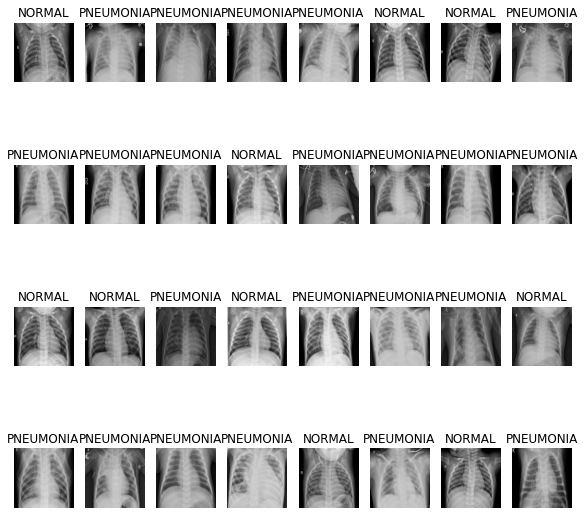

In [15]:
#이미지 배치를 입력하면 여러장의 이미지를 보여줌
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4, math.ceil(BATCH_SIZE/4), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis('off')
        
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## CNN 모델링

### Convolution block

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu'),
        tf.keras.layers.BatchNormalization(), 
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

### Dense block

In [17]:
def dense_block(uints, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(uints, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

**Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용**
- 이런 방법은 variance shift를 억제하는 Batch Normalization과 shift를 유발하는 Dropout을 사용하는 것이 금기시됨

참고 논문 : 

https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf


- 하지만 실용적으로는 두 방법을 같이 쓰는 것이 성능 향상에 도움을 줌

참고 논문 :

https://arxiv.org/pdf/1905.05928.pdf

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
    
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 데이터 imbalance 처리
- 클래스 균형은 소수의 클래스에 특별히 더 큰 관심이 있는 경우에 필요

참고 링크 : https://3months.tistory.com/414

### Weight balancing
- training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss값을 갖도록 가중치를 부여하는 방법
- model.fit()을 호출할 때 파라미터로 넘기는 **class_weight** 에 이러한 클래스별 가중치(**딕셔너리**)를 세팅
- **가중치**는 분야와 최종 성능을 고려해 조정하며, 클래스의 비율에 따라 가중치를 둘 수도 있음


In [19]:
print(COUNT_NORMAL)
print(COUNT_PNEUMONIA)

1072
3113


In [20]:
#weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0  # NORMAL 이미지에 사용할 weight
#weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0  # PNEUMONIA 이미지에 사용할 weight

weight_for_0 = 0.75
weight_for_1 = 0.25

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL : {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA : {:.2f}'.format(weight_for_1))

Weight for NORMAL : 0.75
Weight for PNEUMONIA : 0.25


## 모델 훈련
- 이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU 선택
- 모델은 위에서 만들었던 build_model()을 model에 선언
- 이미지의 라벨이 두 개밖에 없기 때문에 'binary_crossentropy' 사용

In [21]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data = val_ds,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        class_weight = class_weight,
    )

Epoch 1/15
130/130 [==============================] - 65s 384ms/step - loss: 0.1726 - accuracy: 0.7553 - precision: 0.9386 - recall: 0.7175 - val_loss: 0.5831 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 2/15
130/130 [==============================] - 50s 387ms/step - loss: 0.0888 - accuracy: 0.9072 - precision: 0.9785 - recall: 0.8951 - val_loss: 0.7190 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 3/15
130/130 [==============================] - 50s 389ms/step - loss: 0.0676 - accuracy: 0.9344 - precision: 0.9816 - recall: 0.9292 - val_loss: 0.9278 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 4/15
130/130 [==============================] - 52s 398ms/step - loss: 0.0650 - accuracy: 0.9401 - precision: 0.9807 - recall: 0.9379 - val_loss: 1.0945 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 5/15
130/130 [==============================] - 54s 413ms/step - loss: 0.0550 - accura

## 결과 시각화

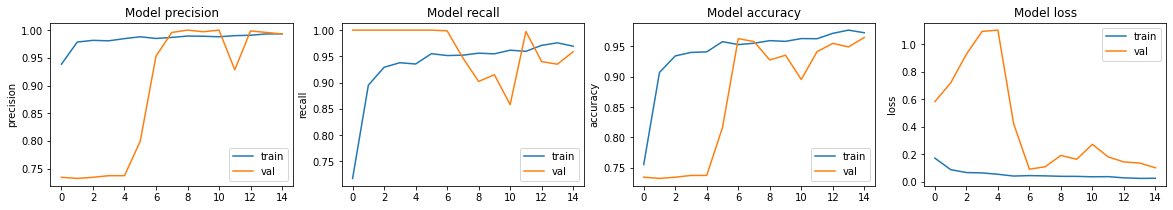

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## 테스트 데이터로 평가

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss}, \nAccuracy: {accuracy}, \nPrecision: {precision}, \nRecall : {recall}')

20/20 [==============================] - 5s 242ms/step - loss: 0.5563 - accuracy: 0.8558 - precision: 0.8261 - recall: 0.9744
Loss: 0.5562812685966492, 
Accuracy: 0.8557692170143127, 
Precision: 0.8260869383811951, 
Recall : 0.9743589758872986


# 회고

1) batch_size : 16 -> 32 : 0.81에서 0.8429로 오름

2) batch_size 32, Dense block에 dropout 제거 : accuracy 0.6987

3) batch_size 32, Dense block에 batchnormalization 제거 : accuracy 0.7019

--------------

**dropout, batchnormalization 둘 다 쓰는게 좋은 데이터**

----------------

4) **batch_size 32, build_model에서 Conv2D레이어 16 -> 32 : accuracy 0.8542**

5) 4)에서 augment(좌우반전) 지정 : accuracy 0.7516

6) 4)에서 conv_block fiter를 2배씩 (32,64,128 -> 64,128,256) : accuracy 0.7612

7) **4)에서 Dense block 2개 2배씩 (128, 64 -> 256, 128) : accuracy 0.7260, recall 1.0**

8) 7)에서 Dense bolck 1개 추가, droprate(0.8, 0.6, 0.4, 0.2) : accuracy 0.8270

9) 8)에서 droprate(0.7, 0.5, 0.3, 0.2), dense(32) 추가 : accuracy 0.8413

10) **9)에서 conv_block 2배씩(32, 64, 128 -> 64, 128, 256) : accuracy 0.8574, recall 0.8359**

------------------

10번의 시도로 보아서는 convolutional layer의 층을 깊게 쌓는 것이 성능 향상에 도움이 되는 것을 확인했다.

하지만 10번 째 시도에서 accuracy가 0.8574라는 가장 높은 성능이 도출되었지만 

recall값은 0.8359로 평균적으로 0.97을 웃도는 성능에 비하면 현저히 저하되었다.

해당 과제의 데이터는 class_weight로 조정해주긴 했지만, 클래스의 비율이 고르지 못한 데이터이다.

또한 폐렴의 여부를 알아내야 하는 문제로 정확도보다 폐렴환자를 잘 찾아내는 **'재현율'**의 평가척도가 적용되어야 한다고 생각한다.

물론 폐렴 환자인 사람과 폐렴 환자가 아닌 사람 모두를 잘 알아내는 정확도와 재현율이 동시에 높은 모델이 가장 우수한 모델이기 때문에,

7번 째 시도에서처럼 재현율이 1.0이고 정확도가 0.72 정도에 머무는 모델이 좋은 모델이라고 하기 어렵다.

즉 모델의 성능을 평가할 때 정확도와 재현율을 모두 고려해야 한다.

따라서 이후 실험은 정확도가 0.85 이상일 경우 재현율이 0.97 이상인 모델을 도출하고자 한다. 

---------------

11) 4)에서 conv_block(32) 삭제 : accuracy 0.7115

12) 4)에서 Conv layer(64) 추가 : accuracy 0.8317

13) 12)에서 Dense(32) 추가 : accuracy 0.7998

14) 4)에서 class_weight = {0 : .75, 1: .25} 설정 : accuracy 0.8044

15) **14)에서 conv layer 2배 (32-> 64) : accuracy 0.8558 recall 0.9744**

15번 째 시도에 위에서 세운 목표를 달성하였다. 

10번 째 시도와 비교해보았을 때 정확도는 0.0016 낮아졌지만 재현율은 0.1385 높아졌다.

다른 시도에서도 그렇듯이 conv_block의 filter와 conv_2d 레이어의 층 수를 높이는 것이 가장 효과적이었다.

'데이터와 처음 만나는 층이 깊어지면서 데이터를 더 자세히 파악하기 때문인가?' 하는 의문이 들었다.

또한

같은 파라미터 세팅에도 다시 커널을 실행시켰을 때 다른 성능이 나왔는데

데이터를 나누는 코드에 랜덤시드를 고정해놓아도 계속 바뀌어서 당황스러웠다.

어느 부분에 랜덤시드를 고정해야 코드를 반복 실행해도 계속해서 같은 성능이 나올지 찾아보고 조원분들과도 얘기해보았는데 

데이터는 고정적으로 나눠져있지만 각 학습단계에서 뽑히는 데이터는 무작위 랜덤추출이어서

성능이 계속 달라질 수밖에 없다는 말을 들었다.